# CS 449 Final Project Update

Due: May 23, 2023 at 11:59pm

## 1. Names and Net IDs

Si Woo Park (swp1316) & Hanhee Yang (hym6769)

## 2. Abstract

*Write a new abstract that describes the motivation for your project and proposed methods. This should reflect any changes you've made, but you'll explain those changes later.*

> In this project, we propose to develop a text classifier that identifies emotions given a sentence using the BERT transformer model. We are using a dataset of Reddit comments with specific emotions as labels and fine tuning BERT model that is pre-trained on uncased English text. After training and testing our model to output a prediction of emotions, we are going to use the vector of emotions as inputs for our emotion-emoji mapping based on the EmoTag dataset. Ultimately, we aim to create a program that outputs an appropriate emoji given any text, which can aid anyone who wants to make their writing more expressive.

## 3. Big Changes

*Describe any major changes that have taken your project in a new direction. What made you decide to make these changes? Were some things easier or harder than you expected?*

> We intended to directly map emotion labels to a specific emoji. However, we have decided to change this by using the emotion-vector before the label prediction and compare that vector into the embedding space of the emojis. We will try to find the closest embedded point in the emoji space and collect the 3 nearest predictions of the emojis.

## 4a. Describe your dataset(s)

*This should be an updated version of your datasets section from your proposal. Write this section as if the reader hasn't read your original proposal. List the datasets you're using, where you found them, and what they contain. Be detailed! For each dataset, what does the data look like? What is the data representation? (e.g., what resolution of images? what length of sequences?) How is the data annotated or labeled? Include citations for the datasets. Include at least one citation of previous work that has used this data, or an explanation of why it hasn't been used before*

> Dataset #1 - Text & Emotions: The current size of our main dataset is 47.1MB and it contains a total of 211k rows. The rows of the dataset include, text, id, author, subreddit, link_id, parent_id, created_utc, rater_id, example_very_clear, and 27 different emotion columns labeled 0 or 1 based on whether the emotion was displayed in the text. The emotions were each individually curated through crowd-sourcing. The columns relevant to our dataset include main the text and emotion columns. The text includes singular sentences that are included as Reddit comments. Some examples of the emotions include admiration, amusement, anger, and annoyance.

> Dataset #2 - Emotions & Emojis: The current size of the main dataset is 19.5MB and it contains a total of 245k rows. This contains the vector representation of the emojis. The columns of the dataset include 8 emotions columns with emotion scores ranging from 0 to 1 in each of those columns. The columns also contain the emoji and the name of the emoji. We will half the size of the predetermined train, validation, and test sets so that the total number of rows is 150 and thus this dataset is less than 1MB. 

## 4b. Load your dataset(s)

*Load at least a few examples and visualize them as best you can*


In [5]:
# !pip install -q datasets
from datasets import load_dataset

dataset = load_dataset("go_emotions", "raw") # simplified
emotions = [
    "admiration",
    "amusement",
    "anger",
    "annoyance",
    "approval",
    "caring",
    "confusion",
    "curiosity",
    "desire",
    "disappointment",
    "disapproval",
    "disgust",
    "embarrassment",
    "excitement",
    "fear",
    "gratitude",
    "grief",
    "joy",
    "love",
    "nervousness",
    "optimism",
    "pride",
    "realization",
    "relief",
    "remorse",
    "sadness",
    'surprise',
    "neutral",
]

i = 0
while i < 10:
    row = dataset['train'][i]
    print('text:',row['text'])
    print('emotion:',end=' ')
    for emotion in emotions:
        if row[emotion] == 1:
            print(emotion,end=' ')
    print('\n')
    i+=1

  0%|          | 0/1 [00:00<?, ?it/s]

text: That game hurt.
emotion: sadness 

text:  >sexuality shouldn’t be a grouping category It makes you different from othet ppl so imo it fits the definition of "grouping" 
emotion: 

text: You do right, if you don't care then fuck 'em!
emotion: neutral 

text: Man I love reddit.
emotion: love 

text: [NAME] was nowhere near them, he was by the Falcon. 
emotion: neutral 

text: Right? Considering it’s such an important document, I should know the damned thing backwards and forwards... thanks again for the help!
emotion: gratitude 

text: He isn't as big, but he's still quite popular. I've heard the same thing about his content. Never watched him much.
emotion: disapproval 

text: That's crazy; I went to a super [RELIGION] high school and I think I can remember 2 girls the entire 4 years that became teen moms.
emotion: amusement 

text: that's adorable asf
emotion: amusement 

text: "Sponge Blurb Pubs Quaw Haha GURR ha AAa!" finale is too real
emotion: amusement 



In [4]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load the CSV file
url = 'https://raw.githubusercontent.com/abushoeb/EmoTag/37d27757d90965d9a9b8a4ff712fe6533e9bb544/data/EmoTag1200-scores-details.csv?plain=1'

# Define the desired columns to use, removed std deviation and other metadata
columns_to_use = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust', 'emoji']

# Read the DataFrame with the desired columns
df = pd.read_csv(url, usecols=columns_to_use)

print(df.head())

   anger  anticipation  disgust  fear   joy  sadness  surprise  trust emoji
0   0.00          0.28     0.00  0.00  0.69     0.06      0.22   0.33     🌈
1   0.00          0.31     0.00  0.00  0.25     0.00      0.06   0.25     🌙
2   0.06          0.08     0.17  0.06  0.42     0.19      0.06   0.11     🌚
3   0.00          0.22     0.00  0.00  0.78     0.00      0.11   0.22     🌞
4   0.00          0.28     0.00  0.00  0.53     0.00      0.25   0.31     🌟


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 4c. Small dataset

*Describe the small dataset you constructed as requested in the project proposal. How many examples did you use? How large was the dataset in total?*

> We constructed a dataset #1 that was a lot smaller than the original dataset. First, since the there were less emotions in the columns of the emoji vector dataset compared to the emotion dataset (dataset #2), we decided to delete rows in the dataset #1 that had emotions present outside the emotions present in dataset #2. After that, we randomly reduced dataset #1 so that only 1k rows were left. Thus, we used 1k rows in total. This reduced our dataset to about less than 1MB in total file storage (down from 47MB). 

## 5. Updated Methods

*This should be an updated version of your methods section from your proposal. Write this section as if the reader hasn't read your original proposal. For example:*

> This is a standard supervised learning task, and we will use `sklearn` and `torch` models to predict what kind of clothing appears in small images. The `sklearn` model will contain one weight per pixel, but our `torch` models will contain millions of weights. We will train our model using Cross-Entropy loss, because...

This is a standard supervised learning task, and we will use `transformers datasets` module to predict the emotions from a givne text. Then, we will map the output emotion vector from the transformer model into the emoji vector space from dataset #2 by computing the vector distances (euclidian and cosine similarity) between the emotion vector and all 150 emoji vectors to output the most similar emojis. 

Specifically we will utilize a pretrained transformer model called BERT (Devlin, 2018). To fine-tune and train this model, we will preprocess the data by tokenizing the text using the AutoTokenizer API. The labels will be attached to the token encodings, resulting in a matrix of shape (batch_size, num_labels). (Demszky, 2020)

During the training process, we will utilize the Trainer object, which incorporates hyperparameters, the pretrained model, training and evaluation datasets, and the tokenizer (https://huggingface.co/docs/transformers/main_classes/trainer#id1). Our model will be based on the AutoModelForSequenceClassification architecture, and we will fine-tune it with our dataset.

To address the multi-label nature of the task, we will employ a Binary Cross Entropy loss for each of the 27 different emotions, combining them using a weighted average. The hyperparameters that can be adjusted include batch size, learning rate, weight decay, and the number of training epochs.

First we will train the BERT model on the preprocessed text and emotion dataset. We will use libraries such as Hugging Face's Transformers or TensorFlow's Keras to train the model. The goal of pretraining is to teach the BERT model how to understand the language and the context of the text.

Once we have emotion vectors, we will map the emotion vector representation into the emoji vector space from dataset #2 using k-means clustering trying both euclidian and cosine similarity distances to output a similar emoji

To evaluate our model's performance, we will apply it to the test dataset and compare the predicted emotion labels with the true labels. We will calculate classification accuracy, f1 score, and ROC AUC metrics and compare them to the performance of a baseline logistic regression model. The logistic regression model will serve as a benchmark, as it is easy to train, and we expect the neural model to outperform it.

To visualize the training progress, we will plot the loss values over multiple epochs, providing a visual representation of the loss's evolution throughout the training process. This will aid in understanding the convergence and optimization of our model.

## 6. Proposed Deliverables

*Copy the deliverables from your proposal and write a sentence saying whether you completed this goal, made progress on this goal, or abandoned this goal. Unless you completed the goal, give an explanation of how it went.*

### 6.1 Previous Essential Goals

1. We want to be able to import and successfully run the transformer model by fine-tuning the neural model and be able to output any emojis. 

2. We want to preprocess our dataset into a format that our transformer model can understand and get trained on.

> We have preprocessed the text into vector format that the BERT model can interpret, but wasn't able to complete the BERT fine tuning process. Thus, we have not used the output of our BERT model for our emotion-emoji vector. However, we have tested the emotion-emoji mapping with example vectors using cosine similarity and euclidean as our distance metrics.

### 6.2 Previous Desired Goals
1. One goal is to be able to fine tune and train the transformer model with our dataset to create a model that can predict correct emojis that align with actual labels.

2. To be significantly better than baseline accuracy. A simple baseline to compare the accuracy to would be the logistic regression. Logistic regression will most likely perform poorly on this dataset beause predictions are based on a linear function. That being said by sweep tuning parameters such as learning rate, number of epochs, batch size, dropout rate, optimizers, and fine-tuning layers will be able to improve accuracy. To avoid overfitting, techniques such as dropout, L1, or L2 regularization can be applied to BERT as well as reducing the number of hidden units in a layer or using cross-validation can be used. 

3. Our goal is to develop a model that can map from text to emotion labels and then use the embeddings of emojis to map from emotion labels to corresponding emojis. Once the BERT model is trained to predict emotions, the predicted emotion label will be used to identify the appropriate emoji. To achieve this, we will use the embeddings of emojis, (using emoji2vec embeddings), to find the emoji that has the highest cosine similarity score with the embedding of the predicted emotion label. This emoji will be outputted as the correct emoji. It's important to note that this approach requires a significant amount of data to train the model effectively, so selecting a high-quality dataset that is appropriate for the task is critical.

> Currently, we have not tested our model against the baseline of logistic regression. We are trying our best to first generate valid emotions before fine tuning to create a model that aligns with actual labels.

### 6.3 Previous Stretch Goals
1. Emotion-specific emojis: Instead of simply mapping from predicted emotions to existing emojis, we want to be able to generate possibly new, emotion-specific emojis. This would involve training a generative model such as Variational Autoencoders (VAE) or Generative Adversarial Networks (GANs) on a large dataset of emojis, then using it to generate new emojis to correspond to specific emotions. 

2. Multi-modal input: Currently, our model is only based on text input. However, other modalities such as images or audio could be used as imput to improve the accuracy of the emoji detection. An idea could be to train a separate model to detect emotions in a images or audio and then combine those results with the text-based model to generate a more robust prediction. 

3. Different models: Our model is based on regular BERT. However, using slightly modified models such as RoBERTa, DistilBERT, or ALBERTA can be used to create models that could be slightly more accurate, faster, or improve fits to different corpora. 

> We have not gotten to this step yet. We have not been able to generate new, emotion specific emojis with GANs. 

> We also have not tried using images or audio to improve th accuracy of emoji detection. 

> We have not tried using similar models, but we will try once we have tested out model against the baseline. We will then compare the BERT large model against different benchmarks that are existing already. 

## 7. Results So Far

*Show the results of your methods trained on your data. You should at least have empirical results for the small dataset described in 4c. Unless you are doing generation or another task where simple models (e.g., linear regression or logistic regression) aren't applicable, we strongly encourage you to compare your initial results against a simple baseline. If you have additional results, you're welcome to include those as well.*

> We haven't gotten any results from our BERT model yet due to our struggles speeding up the fine tuning process and organizing the dataset.

> We compiled a list of emotion vectors and computed the cosine similarity and euclidean distance between the emotion vector and all of the emoji vectors. Then, we returned the top 3 emojis with the best score.

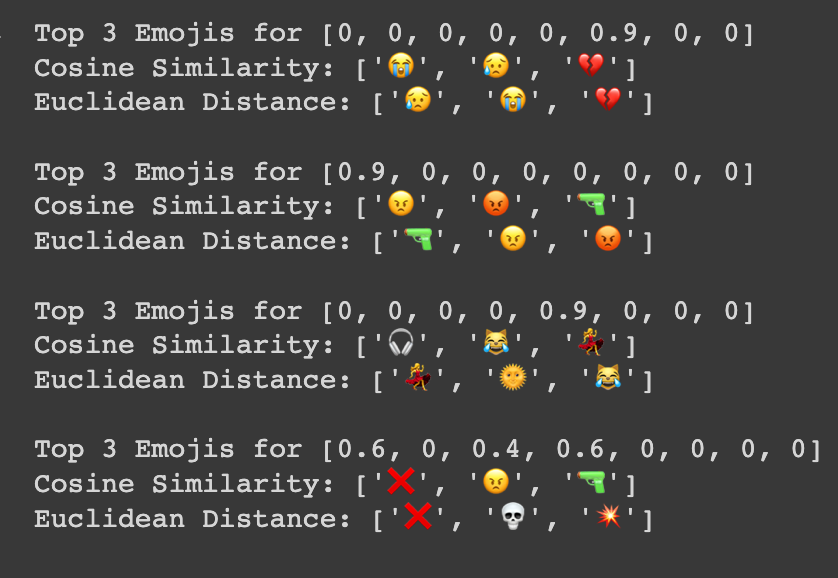

## 8. New Deliverables

*For any proposed deliverables that you did NOT complete or abandon, copy them into these lists below. Then, if you have abandoned or completed your Desired or Stretch goals, add new goals until you have at least two goals per category.*

8.1 New Essential Goals

- Copy the old essential goals that you haven't yet completed or abandoned.

- Don't add any new Essential goals.

8.2 New Desired Goals

- Copy the old desired goals that you haven't yet completed or abandoned.

- Make sure you have at least two Desired goals left to complete here, adding new goals as necessary.

8.3 New Stretch Goals

- Copy the old stretch goals that you haven't yet completed or abandoned.

- Make sure you have at least two Stretch goals left to complete here, adding new goals as necessary.

## 9. Hopes and Concerns

*What's gone well so far? What's been the hardest thing?*

> GOING WELL: So far, we've done well in creating an overall script for predicting emotions with BERT. We were also able to get started on the emotion-emoji mapping.

> GOING HARD: However, we are having a little bit of trouble in being able with the training speed of our model and the layout of the dataset. The large dataset is actually not already divided into train, test, and validation sets as said in the HuggingFace website. It only has a training dataset. We were basing our code on another similar dataset code which has the same format as our large dataset. We have requested to increase the quota for Google Cloud so we could use the GPU to speed up our training process.

## 10. References

*Cite the papers or sources that you used to discover your datasets and/or models, if you didn't include the citation above. For example:*

Cite the papers or sources that you used to discover your datasets and/or models, if you didn't include the citation above.

Demszky, Dorottya, et al. "GoEmotions: A Dataset of Fine-Grained Emotions" https://arxiv.org/pdf/2005.00547v2.pdf (2020).

Shoeb, Abu, et al. "EmoTag - Towards an Emotion-Based Analysis of Emojis

Devlin, Jacob, et al. "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding." arXiv preprint arXiv:1810.04805 (2018).

BERT documentation: https://huggingface.co/docs/transformers/model_doc/bert

Fine-tuning BERT: https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=unjuTtKUjZI3

How to use dataset: https://github.com/huggingface/datasets

Emoji2Vec embeddings paper:https://arxiv.org/pdf/1609.08359v2.pdf

GoEmotions dataset: https://huggingface.co/datasets/go_emotions

EmoTag 1200 dataset: https://github.com/abushoeb/EmoTag/tree/master
> 